In [1]:
from collections import Counter, OrderedDict, defaultdict
import datetime as dt
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf

import json
import pickle
from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')

---

# RQ1: Relation between Box Office sales and number of quotes of a movie

- Is there a tendency between number of sold tickets and the 'hype' about a movie as it appears in the news paper media?


For this question, we will only consider the total number of quotes on a movie found in the Quotebank dataset. We start with the IMDb movie dataset and filter out the top 50 movies in terms of *usa_gross_income*. Then we filter the Quotebank dataset on the titles of these movies and count the occurences.

In [4]:
df = pd.read_csv('./exploratory/data/IMDb/IMDb movies.csv')

We do a preprocessing on the imdb dataset. Transforming years, incomes and budgest to integers, publisd dates to datetime object.

In [5]:
def clean_imdb(df):
    imdb = df.rename(columns = {'worlwide_gross_income':'worldwide_gross_income'})
    imdb = imdb.drop(imdb.index[83917])
    imdb['year'] = imdb['year'].astype(int)
    imdb = imdb[imdb['year']>2014]
    imdb = imdb.dropna()
    imdb['budget'] = imdb['budget'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(int)
    imdb['worldwide_gross_income'] = imdb['worldwide_gross_income'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(int)
    imdb['usa_gross_income'] = imdb['usa_gross_income'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(int)
    imdb['date_published'] = pd.to_datetime(imdb['date_published'])
    return imdb

imdb = clean_imdb(df)

Tehre are movie titles which might be really frequent in the Quotebank dataset, the corresponding quote might come from different context, making our analysis biased so we filter them out, the result is a dictionary with the relevant movie titles, we run them through our Quotebank filter pipeline. 

In [6]:
ignore = {2015: ['Home',  'Spy', 'Sisters',  'Joy'],
2016: ['Sing', 'Trolls',  'Split'],
2017: ['It',   'Coco'],
2018: ['Halloween'],
2019: ['Us', 'Glass', 'Yesterday',  'Midway'],
2020: ['Tesla',  'Emma.', 'Wendy']}

relevant_movies = []
titles_by_year = defaultdict(list)
for year in range(2015, 2021):
    titles_by_year[year] = list(imdb[imdb['year']==year].nlargest(50, columns='usa_gross_income')['original_title'])
    relevant_movies.append(imdb[imdb['year']==year].nlargest(50, columns='usa_gross_income')[['original_title', 'usa_gross_income', 'year']])
    for title in ignore[year]:
        titles_by_year[year].remove(title)

movies_df = pd.concat(relevant_movies)

For a movie released in year $x$, we look for quotes containing the title (or subtitle) of the movie in year $x$ and $x+1$. In this way we will have information about the hype before the publish date and see the afterlife as well. The filtering happened using in a different python script, we just load the json files containing the results.

In [9]:
quotes_by_movies_by_year = defaultdict(list)

for i in range(2015, 2021):
    path = f'./exploratory/data/rq1/final_movie_quotes{i}.json'
    with open(path, 'r') as f:
        data = json.load(f)
    for (k, v) in data.items():
        quotes_by_movies_by_year[k].append(v)

quotes_by_movies = defaultdict(list)

for (k,v) in quotes_by_movies_by_year.items():
    quotes_by_movies[k] = sum(v)

quotes_by_movies = OrderedDict(sorted(quotes_by_movies.items(), key=lambda t: -t[1]))

In [10]:
for i, (k,v) in enumerate(quotes_by_movies.items()):
    if i < 10:
        print(f"{k}, {v}")

Men in Black: International, 38245
Kong: Skull Island, 16395
Mission: Impossible - Fallout, 11447
Star Wars: Episode VIII - The Last Jedi, 9402
Star Wars: Episode IX - The Rise of Skywalker, 9197
Avengers: Endgame, 7692
Thor: Ragnarok, 7537
Star Wars: Episode VII - The Force Awakens, 6837
Avengers: Infinity War, 6215
Logan, 5692


Text(0.5, 0, 'log rank of movie')

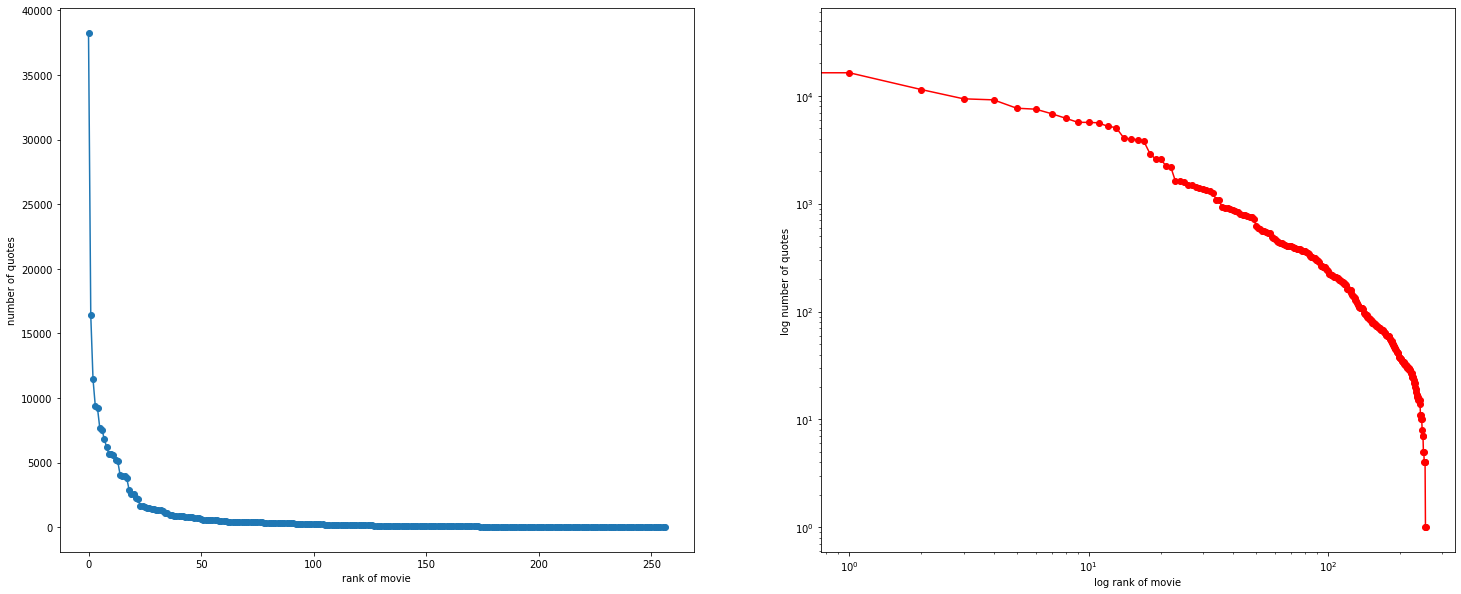

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,10)) # here we should decide a split (0-50 vs 50-100?)
ax[0].plot(quotes_by_movies.values(), marker='o')
ax[0].set_ylabel('number of quotes')
ax[0].set_xlabel('rank of movie')
ax[1].loglog(quotes_by_movies.values(), marker='o', color='red')
ax[1].set_ylabel('log number of quotes')
ax[1].set_xlabel('log rank of movie')

We sort the movies by number of quotes and visualize the distribution. It looks like a power low, but if we change to log-log axes, we can see it is clearly not a straight line.

Now we megre the information about quotes into our *movies_df* dataframe.

In [12]:
numOccurrences = pd.DataFrame()
numOccurrences['original_title'] = quotes_by_movies.keys()
numOccurrences['number_of_quotes'] = quotes_by_movies.values()
movies_df= pd.merge(movies_df,numOccurrences, how='left', on='original_title') 
movies_df

,original_title,usa_gross_income,year,number_of_quotes
0,Star Wars: Episode VII - The Force Awakens,936662225,2015,6837.0
1,Jurassic World,652270625,2015,389.0
2,Avengers: Age of Ultron,459005868,2015,1493.0
3,Inside Out,356921711,2015,187.0
4,Fast & Furious 7,353007020,2015,29.0
...,...,...,...,...
270,The Rhythm Section,5437971,2020,10.0
271,The Tax Collector,942666,2020,1.0
272,Cut Throat City,507436,2020,NaN
273,Wendy,143518,2020,NaN


## Proposed method: Linear regression between total number of quotes on a movie and domestic box office revenue.

We run a linear regression to investigate whether more popular movies tend to have higher media coverage or not. We use statsmodels ols function to do so.

In [13]:
res = smf.ols(formula='usa_gross_income ~ number_of_quotes', data=movies_df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       usa_gross_income   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     19.55
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           1.45e-05
Time:                        10:27:23   Log-Likelihood:                -5185.3
No. Observations:                 257   AIC:                         1.037e+04
Df Residuals:                     255   BIC:                         1.038e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.499e+08   9.15e+06  

We conclude that the predictor *number_of_quotes* is indeed significant, since its small p-value. So in general the more successful a movie, the more media coverage it gets. 

<AxesSubplot:title={'center':'Number of quotes vs worldwide income of selected movies per year'}, xlabel='usa_gross_income', ylabel='number_of_quotes'>

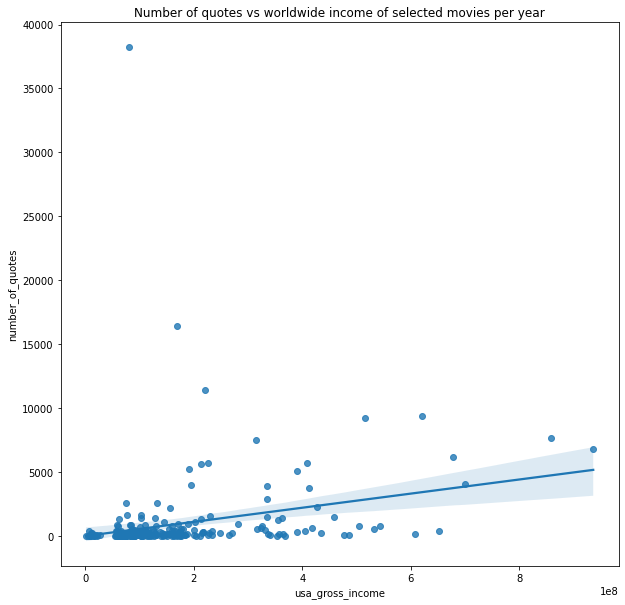

In [14]:
plt.figure(figsize = (10,10))
plt.title('Number of quotes vs worldwide income of selected movies per year')
sns.regplot(data=movies_df, x='usa_gross_income', y='number_of_quotes')

---

## Proposed Method: Observational study with propensity score matching

We calculate propensity score with logistic regression, based on movie attributes on IMDb data on few quote vs many quote movies and compare the results with box office data.

We will add the following features from the IMDb dataset: *avg_vote*, *budget*, *duration*, *metascore*, *votes*. Furthermore, we create a *genres* one hot feature as well.

In [15]:
movies_df = movies_df.merge(imdb[['original_title', 'avg_vote', 'budget','duration', 'metascore', 'votes','genre']], how='left', on='original_title')
movies_df

,original_title,usa_gross_income,year,number_of_quotes,avg_vote,budget,duration,metascore,votes,genre
0,Star Wars: Episode VII - The Force Awakens,936662225,2015,6837.0,7.9,245000000,138,80.0,845102,"Action, Adventure, Sci-Fi"
1,Jurassic World,652270625,2015,389.0,7.0,150000000,124,59.0,569512,"Action, Adventure, Sci-Fi"
2,Avengers: Age of Ultron,459005868,2015,1493.0,7.3,250000000,141,66.0,722685,"Action, Adventure, Sci-Fi"
3,Inside Out,356921711,2015,187.0,8.1,175000000,95,94.0,592575,"Animation, Adventure, Comedy"
4,Fast & Furious 7,353007020,2015,29.0,7.1,190000000,137,67.0,353562,"Action, Adventure, Thriller"
...,...,...,...,...,...,...,...,...,...,...
270,The Rhythm Section,5437971,2020,10.0,5.2,50000000,109,45.0,8816,"Action, Drama, Mystery"
271,The Tax Collector,942666,2020,1.0,4.7,30000000,95,22.0,4862,"Action, Crime, Drama"
272,Cut Throat City,507436,2020,NaN,4.3,8000000,123,67.0,141,"Action, Crime, Drama"
273,Wendy,143518,2020,NaN,5.7,6000000,111,54.0,1405,"Drama, Fantasy"


We transform our continous variable **number_of_quotes** into a cathegorical one, we chose a threshold for $500$ (approx $20\%$ of the data), if a movie has more quotes than the threshold, we cathegorize it as highly_quoted, denoted with the dummy variable **highly_quoted**.

In [16]:
movies_df['highly_quoted'] = 0
threshold = 500 #this might have to be bigger
movies_df.loc[movies_df['number_of_quotes']> threshold, 'highly_quoted'] = 1

In order to calculate propensity scores, we perform a logisitc regression using the statsmodel library. We want to study whether the number of quotes on a movie will have an effect on its performance in the box office, so we will regress the cathegoricl variable *highly_quoted* against covariates from the IMDb dataset. Note, that we do not include *usa_gross_income* as covariate, since this is our target variable, in the end we are interested the effect on this variabe.

In [17]:
import statsmodels.api as sm
columns = list(set(list(movies_df.columns)) - set(['original_title','usa_gross_income', 'number_of_quotes','highly_quoted', 'genre']))
mod = sm.Logit(movies_df['highly_quoted'], movies_df[columns])

res = mod.fit()

# Extract the estimated propensity scores
movies_df['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.374912
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          highly_quoted   No. Observations:                  275
Model:                          Logit   Df Residuals:                      269
Method:                           MLE   Df Model:                            5
Date:                Fri, 10 Dec 2021   Pseudo R-squ.:                  0.2722
Time:                        10:27:33   Log-Likelihood:                -103.10
converged:                       True   LL-Null:                       -141.67
Covariance Type:            nonrobust   LLR p-value:                 3.331e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
metascore     -0.0050      0.017     -0.286      0.775      -0.039       0.029
duration       0.0084      0.

In [18]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

Based on the propensity score we calculate similarity between the two gropus and make a bipartite graph. The edge weight between two nodes are the similarity scores. We want to find a maximal weight matching between the two groups (**highly_quoted** and **lowly_quoted**). The matching is found using the Hungarian algorithm, the graph is stored in a **networkx** object.

In [19]:
# Separate the treatment and control groups
highly_quoted_df = movies_df[movies_df['highly_quoted'] == 1]
lowly_quoted_df = movies_df[movies_df['highly_quoted'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for l_id, l_row in lowly_quoted_df.iterrows():
    for h_id, h_row in highly_quoted_df.iterrows():

        similarity = get_similarity(l_row['Propensity_score'],h_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(l_id, h_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

# Make a 'mask' of the indexes of the matched movies
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

Now we have a matching, it's time to check the means and the distributions of our filtered data.

In [20]:
balanced_df = movies_df.loc[matched]
balanced_highly_quoted_df = balanced_df[balanced_df['highly_quoted'] == 1]
balanced_lowly_quoted_df = balanced_df[balanced_df['highly_quoted'] == 0]

In [21]:
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

In [22]:
high_CI = bootstrap_CI(balanced_highly_quoted_df['usa_gross_income'], 1000)
low_CI = bootstrap_CI(balanced_lowly_quoted_df['usa_gross_income'], 1000)
high_mean = balanced_highly_quoted_df['usa_gross_income'].mean()
low_mean = balanced_lowly_quoted_df['usa_gross_income'].mean()

print(f'mean usa gross income on highly quotes moves: {high_mean},    95%-CI: {high_CI} ')
print(f'mean usa gross income on lowly quotes moves: {low_mean},     95%-CI:  {low_CI}')

mean usa gross income on highly quotes moves: 281844737.2241379,    95%-CI: [232574980.3810345, 332276980.2978448] 
mean usa gross income on lowly quotes moves: 197580866.31034482,     95%-CI:  [167116874.5685345, 234068564.3262931]


In [23]:
stats.ttest_ind(balanced_highly_quoted_df['usa_gross_income'], balanced_lowly_quoted_df['usa_gross_income'], equal_var=False)

Ttest_indResult(statistic=2.640567346545581, pvalue=0.009616817095550331)

More quoted movies have higher mean gross income, the t-test and the confidence intervals point out they do differ significantly, we conclude that quotes have a significant positive effect on the gross income.

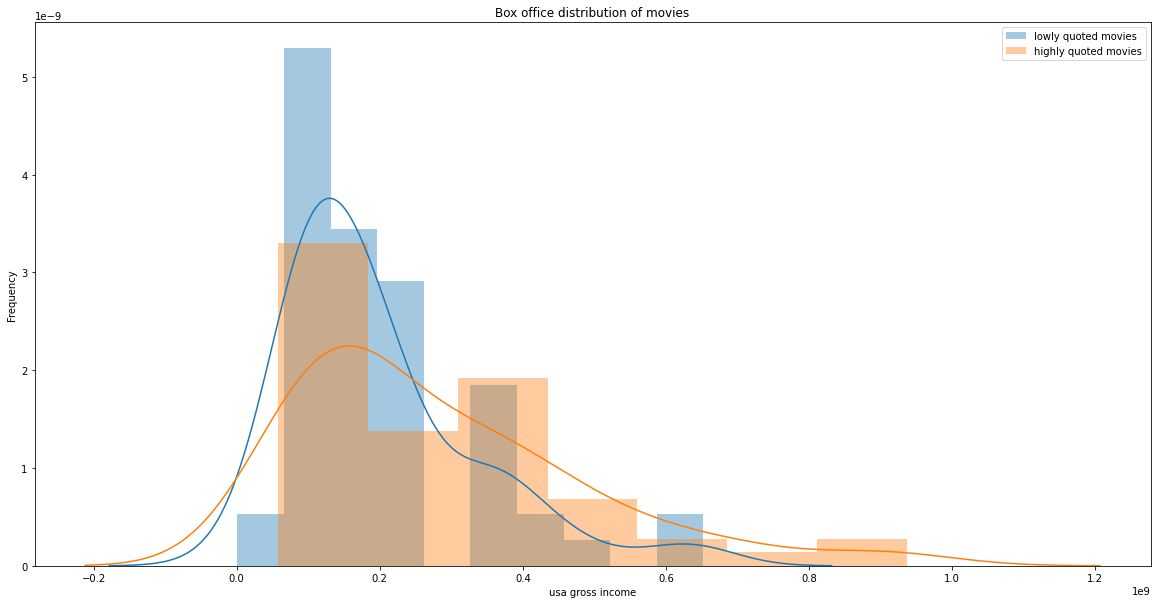

In [24]:
fig, ax = plt.subplots(figsize =(20,10))
sns.distplot(balanced_lowly_quoted_df['usa_gross_income'], hist=True, label='lowly quoted movies', ax=ax)
sns.distplot(balanced_highly_quoted_df['usa_gross_income'], hist=True, label='highly quoted movies', ax=ax)
ax.set(title='Box office distribution of movies',xlabel='usa gross income', ylabel='Frequency')
plt.legend()
plt.show()

---

# RQ5: The effect of COVID on media coverage of movies.

## Proposed method: Calculate mean number of quotes on movies between 2015-2019 on a daily basis, calculate confidence intervals (bootstrapping), compare with 2020 data

In [28]:
quotes = pd.read_pickle('./exploratory/data/Quotebank_sentiment.pkl')

In [30]:
with open('./exploratory/data/rq1/top_10.json') as json_file:
    top10_movies = json.load(json_file)

In [31]:
def count_quotes_by_movies(quotes, top10_movies):

    pre_covid_movies = top10_movies[str(2015)] + top10_movies[str(2016)] + top10_movies[str(2017)] + top10_movies[str(2018)] + top10_movies[str(2019)]

    covid_movies = top10_movies[str(2020)]

    all_quotes_by_date = []
    for movie in pre_covid_movies:
        df = quotes[quotes['movie'] == movie]['date']
        df = dict(Counter(df))
        all_quotes_by_date.append({k[5:]: v for k, v in df.items()})

    final = defaultdict(list)
    for dict_ in all_quotes_by_date:
        for k, v in dict_.items():
            final[k].append(v)

    covid_quotes_by_date = []
    for movie in covid_movies:
        df = quotes[quotes['movie'] == movie]['date']
        df = dict(Counter(df))
        covid_quotes_by_date.append({k[5:]: v for k, v in df.items()})

    covid_final = defaultdict(list)
    for dict_ in covid_quotes_by_date:
        for k, v in dict_.items():
            covid_final[k].append(v)

    return final, covid_final

def calculate_average_by_date(final, covid_final):
    final = OrderedDict(sorted(final.items(), key=lambda t: t[0]))
    covid_final = OrderedDict(sorted(covid_final.items(), key=lambda t: t[0]))
    averages = OrderedDict()
    covid_averages = OrderedDict()

    for k,v in final.items():
        averages[k] = np.array(v).mean()
        covid_averages[k] = 0
    
    for k,v in covid_final.items():
        covid_averages[k] = np.array(v).mean()

    return averages, covid_averages

In [32]:
final, covid_final = count_quotes_by_movies(quotes, top10_movies)
final = OrderedDict(sorted(final.items(), key=lambda t: t[0]))
covid_final = OrderedDict(sorted(covid_final.items(), key=lambda t: t[0]))
averages, covid_averages = calculate_average_by_date(final, covid_final)

2020 is a leap year, so we get rid of 29 of February

In [33]:
leap = covid_averages['02-29']
print(f'number of quotes on February 29: {leap}')
del covid_averages['02-29']

number of quotes on February 29: 3.0


In [34]:
#bootsrap confidence intervals
lens = []
for k,v in tqdm(final.items()):
    lens.append(len(v))
avg = sum(lens)/len(lens)
print(f'average number of movies being quoted: {avg}')

lower_bound = []
upper_bound = []
for k,v in tqdm(final.items()):
    if len(v) < int(avg):
        x = np.zeros(int(avg)) #padding with zeros if we have few observations
        x[:len(v)] = v
    l, u = bootstrap_CI(x, 1000)
    lower_bound.append(l)
    upper_bound.append(u)

100%|██████████| 365/365 [00:00<00:00, 512013.70it/s]


average number of movies being quoted: 21.583561643835615


100%|██████████| 365/365 [00:20<00:00, 17.50it/s]


Text(0, 0.5, 'average number of quotes')

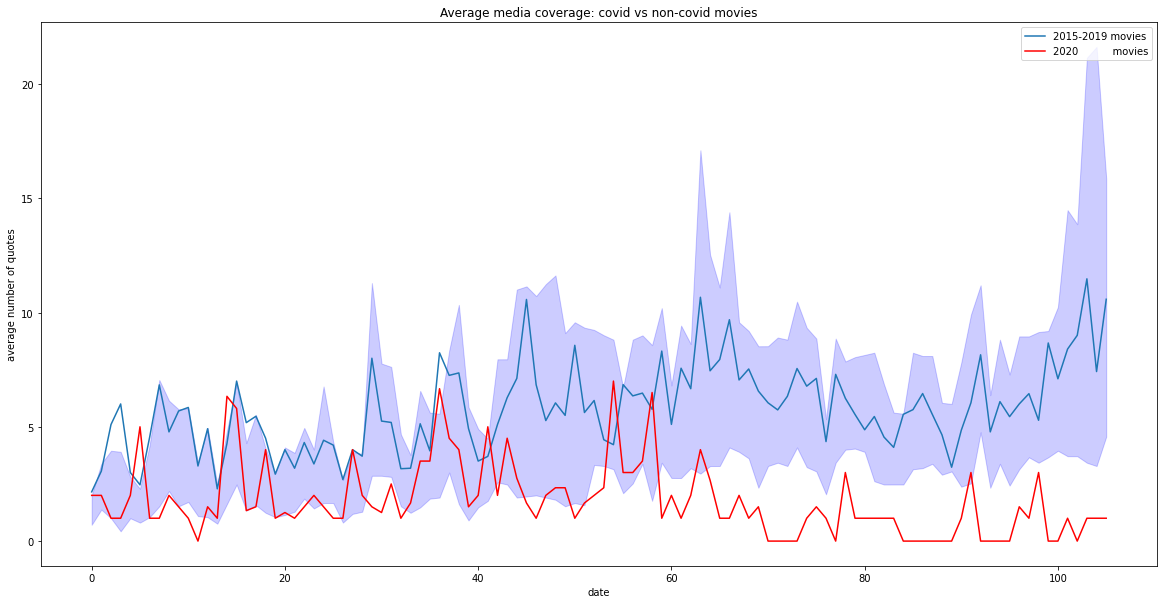

In [35]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_title('Average media coverage: covid vs non-covid movies')
plt.fill_between(np.arange(106), lower_bound[:106], upper_bound[:106], alpha=.2, color='blue')
sns.lineplot(np.arange(106), list(averages.values())[:106], ax=ax, label='2015-2019 movies')
sns.lineplot(np.arange(106), list(covid_averages.values())[:106], ax=ax, color='red', label='2020           movies')
ax.set_xlabel('date')
ax.set_ylabel('average number of quotes')

The plot suggests that from the beginning of march in 2020, movies were quoted less than in the years before. The red line is not in the confidence interval, so we can conclude the difference is significant. This means the covid pendemic had a negative effect on the news about movies.

---

## Proposed method: Use regression for comparison of the mean number of quotes across movies in covid and non-covid period, use t-test for comparison of means.

We have to be extra careful in this task again, 2020 data is until 04-16, so in ored to make it comperable we will only consider quotes in this period between 2015-2019.

In [36]:
from datetime import date
filtered = []

quotes['date'] = pd.to_datetime(quotes['date'])

#filtering quotes before 2020 to get quotes only before 04-16 (we only have data for this period in 2020)
for year in range(2015, 2020):
    value_to_check = pd.Timestamp(year, 4, 16)
    filter_mask = quotes['date'] < value_to_check
    filtered.append(quotes[filter_mask])

#filteirng quotes in 2020
value_to_check = pd.Timestamp(2019, 12, 31)  
filter_mask = quotes['date'] > value_to_check
filtered.append(quotes[filter_mask])
quotes_before_04_16 = pd.concat(filtered)

covid = df.merge(quotes_before_04_16.groupby('movie').sum()['numOccurrences'],left_on='original_title', right_index=True) #merge quotes with movies
covid = covid[['original_title','year', 'numOccurrences']]
covid['year'] = covid['year'].astype(int)
covid = covid[covid['year']>2014]
covid['covid'] = 0
covid.loc[covid['year'] == 2020, 'covid'] = 1 #adding dummy variable whether a movie came out in 2020 or not (effected by the pandemic)

<AxesSubplot:xlabel='covid', ylabel='numOccurrences'>

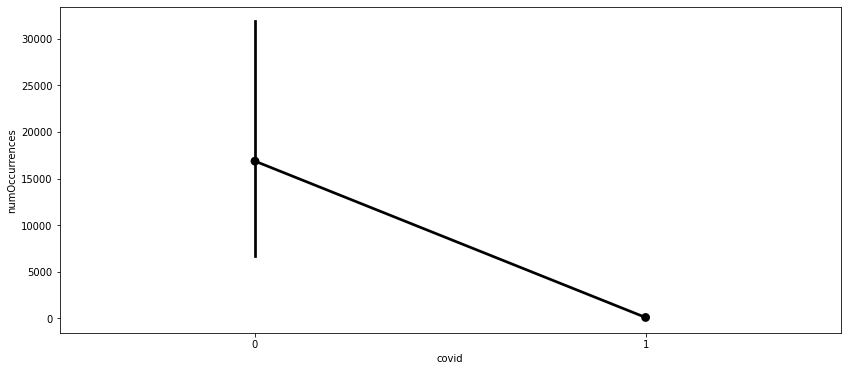

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize =(14,6))
sns.pointplot(x='covid', y='numOccurrences', data=covid, color='black', ax=ax)

The plot suggests that the difference is significant, the two dot represent the mean of the data and the lines are the bootstrapped confidence intervals, since the intervals do not overlap, the difference is significant. We can come to similar conclusion using linear regression

In [38]:
res = smf.ols(formula='numOccurrences ~ covid', data=covid).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         numOccurrences   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9796
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.327
Time:                        10:32:28   Log-Likelihood:                -686.56
No. Observations:                  57   AIC:                             1377.
Df Residuals:                      55   BIC:                             1381.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.686e+04   5930.632      2.843      0.0

We can observe the following:
$$ \text{number of quotes} = 2264 - 2199 \times \text{covid}$$

From the regression we can see immediately see that the mean score for non-covid movies is the intercept ($2264 $), and adding the dummy indicator *covid*, we get the mean score for movies in 2020, which is $66$.